# Movie Lens Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import spearmanr
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MovieLens/User_ratings_For_Movie.csv')
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MovieLens/movies.csv')

## Data Cleaning

### Inspecting Data

In [4]:
print(ratings.head())
print(movies.head())

   userId  movieId  rating     timestamp
0       1        1     4.0  1.225735e+09
1       1      110     4.0  1.225865e+09
2       1      158     4.0  1.225734e+09
3       1      260     4.5  1.225735e+09
4       1      356     5.0  1.225735e+09
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [5]:
ratings.info()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125352 entries, 0 to 125351
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125352 non-null  int64  
 1   movieId    125352 non-null  int64  
 2   rating     125352 non-null  float64
 3   timestamp  125351 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


### Handling Missing Values

In [6]:
# Check for missing values (NaN or null values)
print(ratings.isnull().sum())
print(movies.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    1
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


### Merge Datasets

In [7]:
df = pd.merge(ratings, movies, on='movieId')
print(df.head())

   userId  movieId  rating     timestamp             title  \
0       1        1     4.0  1.225735e+09  Toy Story (1995)   
1       2        1     5.0  8.358160e+08  Toy Story (1995)   
2       7        1     4.0  9.745180e+08  Toy Story (1995)   
3      10        1     3.0  1.430666e+09  Toy Story (1995)   
4      12        1     5.0  8.625007e+08  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125352 entries, 0 to 125351
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125352 non-null  int64  
 1   movieId    125352 non-null  int64  
 2   rating     125352 non-null  float64
 3   timestamp  125351 non-null  float64
 4   title      125352 non-null  object 
 5   genres     125352 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


### Drop Unused Columns

In [9]:
print(df['timestamp'].isnull().sum())

1


In [10]:
df = df.dropna(subset=['timestamp'])

In [11]:
# Assuming 'df' is your DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


<ipython-input-11-5c21e5e4e08c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


In [12]:
#df.drop(['timestamp'], axis=1, inplace=True)

In [13]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## EDA

### Descriptive Statistics

In [14]:
df.describe()

,userId,movieId,rating,timestamp
count,125351.000000,125351.000000,125351.000000,125351
mean,646.079896,27844.978453,3.584323,2010-05-15 12:13:53.069628672
min,1.000000,1.000000,0.500000,1996-02-29 16:14:11
25%,318.000000,1208.000000,3.000000,2003-05-24 21:43:08.500000
50%,624.000000,3168.000000,4.000000,2010-03-16 14:47:28
75%,974.000000,40815.000000,4.500000,2017-08-25 04:09:02
max,1293.000000,288269.000000,5.000000,2023-07-20 07:26:24
std,372.152625,48904.887953,1.049878,NaN


In [15]:
# It counts the occurrences of each genre in the 'genres' column using value_counts() method.
df['genres'].value_counts()

genres
Drama                                         7958
Comedy                                        7150
Comedy|Romance                                4122
Drama|Romance                                 3534
Action|Adventure|Sci-Fi                       3498
                                              ... 
Crime|Drama|Mystery|Romance                      1
Comedy|Mystery|Romance                           1
Drama|Fantasy|War                                1
Children|Documentary                             1
Adventure|Animation|Fantasy|Musical|Sci-Fi       1
Name: count, Length: 976, dtype: int64

In [16]:
# Understanding the data
df.describe(include='all')

,userId,movieId,rating,timestamp,title,genres
count,125351.000000,125351.000000,125351.000000,125351,125351,125351
unique,NaN,NaN,NaN,NaN,11036,976
top,NaN,NaN,NaN,NaN,"Shawshank Redemption, The (1994)",Drama
freq,NaN,NaN,NaN,NaN,476,7958
mean,646.079896,27844.978453,3.584323,2010-05-15 12:13:53.069628672,NaN,NaN
min,1.000000,1.000000,0.500000,1996-02-29 16:14:11,NaN,NaN
25%,318.000000,1208.000000,3.000000,2003-05-24 21:43:08.500000,NaN,NaN
50%,624.000000,3168.000000,4.000000,2010-03-16 14:47:28,NaN,NaN
75%,974.000000,40815.000000,4.500000,2017-08-25 04:09:02,NaN,NaN
max,1293.000000,288269.000000,5.000000,2023-07-20 07:26:24,NaN,NaN


### Visualizing the Distribution

#### Normality Check

In [17]:
# Perform Anderson-Darling test on 'rating' column
anderson_test = stats.anderson(df['rating'], dist='norm')
print(f"Anderson-Darling Test statistic: {anderson_test.statistic}, critical values: {anderson_test.critical_values}")

# Interpretation of the output
if anderson_test.statistic > max(anderson_test.critical_values):
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data might be normal.")


Anderson-Darling Test statistic: 2731.1566854082484, critical values: [0.576 0.656 0.787 0.918 1.092]
Reject null hypothesis: Data is not normally distributed.


#### Histogram

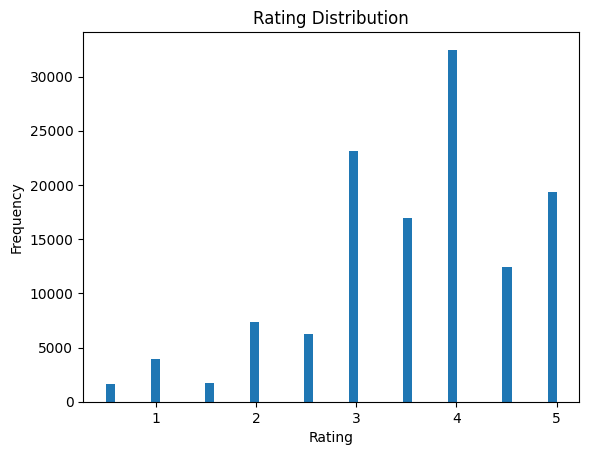

In [18]:
plt.hist(df['rating'], bins=50)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### Boxplot

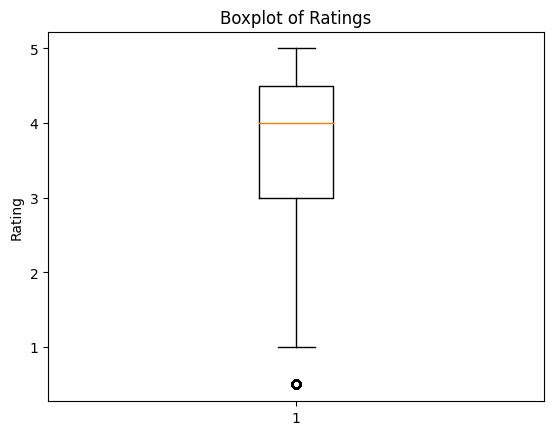

In [19]:
plt.boxplot(df['rating'])
plt.title('Boxplot of Ratings')
plt.ylabel('Rating')
plt.show()

The ratings go from 1 to 5. The box in the center of the plot contains the middle 50% of the ratings. The line in the middle of the box represents the median rating, which is 3. The whiskers extend out from the top and bottom of the box. They show the range of the rest of the data, excluding outliers. In this case, the whiskers extend to 1 at the bottom and 4 at the top. This means that there are some ratings that are lower than 1 or higher than 4, but not many. These are considered outliers and are plotted as individual points beyond the whiskers.

- The ratings mostly range from around
- The median rating appears to be around  indicating that half of the ratings are above  and half are below.
- There are a few outliers on the lower side, indicating that there are a few unusually low ratings compared to the rest of the data.
- There are no outliers on the higher side, so the highest ratings don't differ as much from the general dataset as the lowest ones do.

#### Correlation Matrix

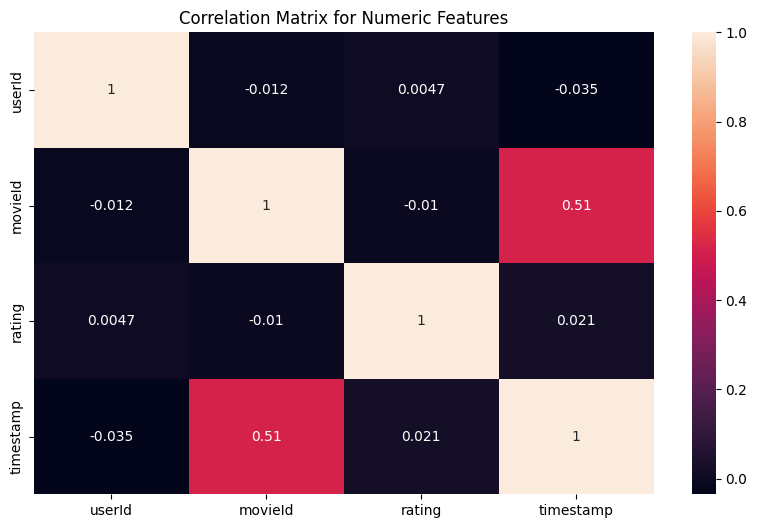

In [20]:
# Drop non-numeric columns before calculating correlation matrix
numeric_df = df.drop(columns=['title', 'genres'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix for Numeric Features')
plt.show()


#### Data Distribution

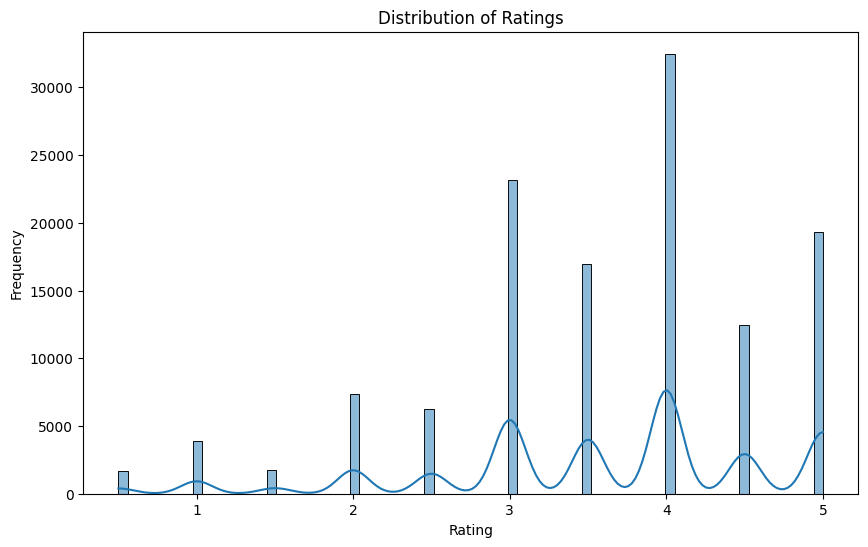

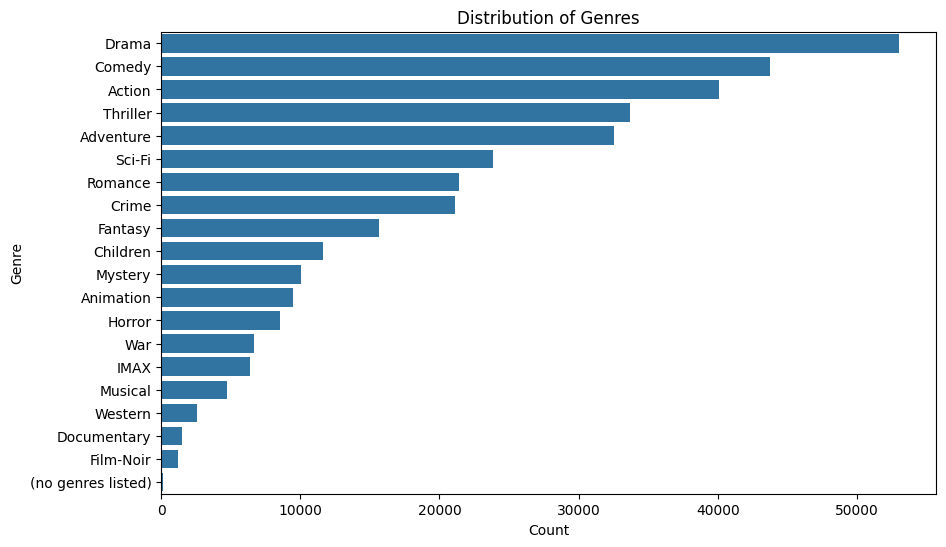

In [21]:
# Ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Genres distribution
plt.figure(figsize=(10, 6))
genres = df['genres'].str.split('|').explode()
sns.countplot(y=genres, order=genres.value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

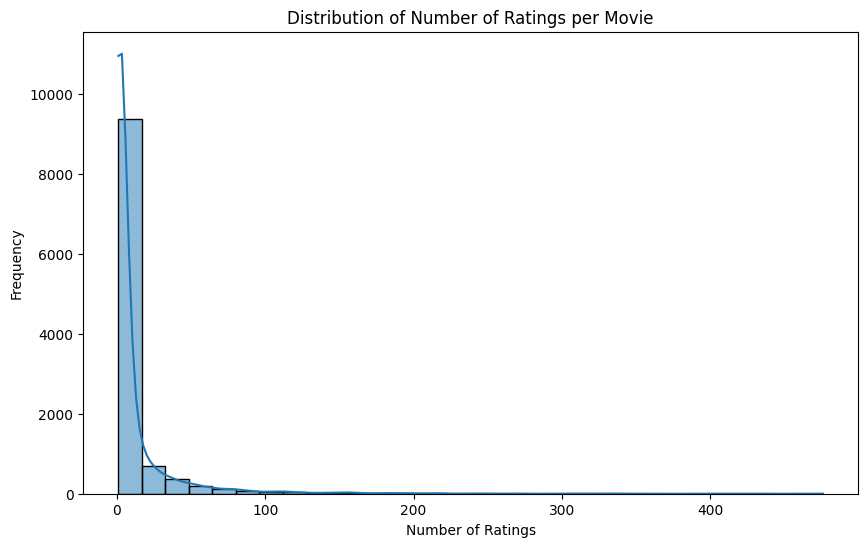

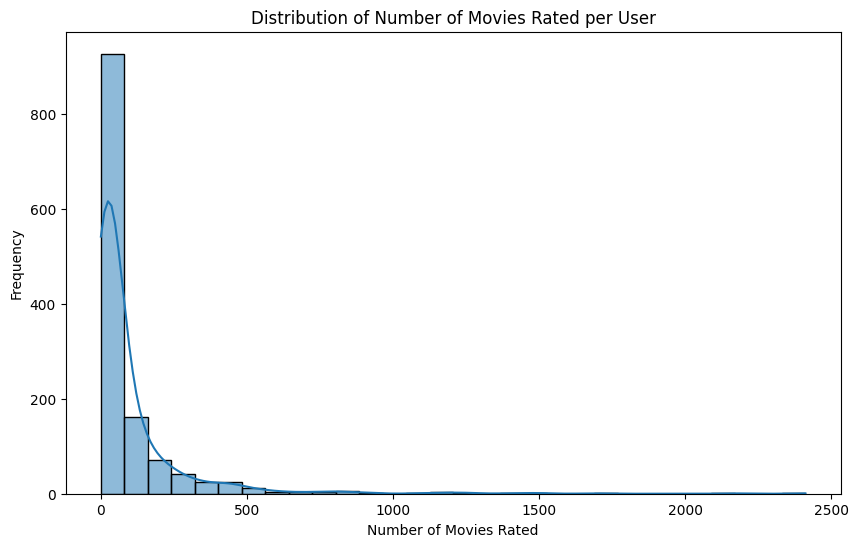

In [22]:
# Distribution of the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('movieId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Distribution of the number of movies rated per user
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('userId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Movies Rated per User')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Frequency')
plt.show()


### Detecting and Handling Outliers

In [23]:
# Detecting outliers in 'rating' using IQR
def count_outliers(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature]
    return outliers.count()

Q1 = df['rating'].quantile(0.25)
Q3 = df['rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Outliers for the 'rating' column
print("Number of outliers in 'rating':", count_outliers(df, 'rating'))


Number of outliers in 'rating': 1660


In [24]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Encoding Categorical Variables

In [25]:
df_genres = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, df_genres], axis=1)

In [26]:
df.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### Creating New Features

In [27]:
# Extracting the number of genres per movie as a new feature
df['num_genres'] = df['genres'].apply(lambda x: len(x.split('|')))

In [28]:
df.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5


In [29]:
# Correlation between 'rating' and 'num_genres'
spearman_corr, spearman_p_value = spearmanr(df['rating'], df['num_genres'])
print(f"Spearman's Correlation Coefficient: {spearman_corr}, P-value: {spearman_p_value}")

# Interpretation of Spearman's correlation
if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("There is a statistically significant positive correlation between 'rating' and 'num_genres'.")
    elif spearman_corr < 0:
        print("There is a statistically significant negative correlation between 'rating' and 'num_genres'.")
    else:
        print("There is a statistically significant but no linear correlation between 'rating' and 'num_genres'.")
else:
    print("There is no statistically significant correlation between 'rating' and 'num_genres'.")


Spearman's Correlation Coefficient: 0.0031106949888586475, P-value: 0.27075241756247964
There is no statistically significant correlation between 'rating' and 'num_genres'.


## Model Implementation

### 1. Create Train/Validation/Test Datasets

In [30]:
# splitting the data into three parts: training, validation, and testing datasets.

train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

### 2. Preprocessing Data

In [31]:
def create_user_item_matrix(df):    #This line creates a user-item matrix using pivot_table and fills missing values with 0.
    """
    Transforms the DataFrame into a user-item matrix
    """
    pivot_table = df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    return pivot_table

train_matrix_df = create_user_item_matrix(train_data)
validation_matrix_df = create_user_item_matrix(validation_data)
test_matrix_df = create_user_item_matrix(test_data)


# Convert the DataFrame to a sparse matrix
train_matrix = csr_matrix(train_matrix_df.values)
validation_matrix = csr_matrix(validation_matrix_df.values)
test_matrix = csr_matrix(test_matrix_df.values)

### 3. Applying SVD on Training Data

In [32]:
# Perform SVD on the CSR matrix
U, sigma, Vt = svds(train_matrix, k=50)  # k is the number of singular values and vectors
sigma_diag_matrix = np.diag(sigma)

# Convert the matrices back to DataFrames for easier interpretation and processing
user_factors_df = pd.DataFrame(U, index=train_matrix_df.index)
movie_factors_df = pd.DataFrame(Vt.T, index=train_matrix_df.columns)  # Transpose Vt to align with movie IDs

In [33]:
def predict_ratings(user_factors, sigma_diag_matrix, item_factors, user_item_matrix):
    # Prediction using dot product
    predictions = np.dot(np.dot(user_factors, sigma_diag_matrix), item_factors.T)

    # Convert predictions to a DataFrame with the same structure as the training set
    preds_df_temp = pd.DataFrame(predictions, columns=train_matrix_df.columns, index=train_matrix_df.index)

    # Reindex the predictions DataFrame to match the validation/test user-item matrix, filling missing values with 0
    preds_df = preds_df_temp.reindex(index=user_item_matrix.index, columns=user_item_matrix.columns, fill_value=0)

    return preds_df


In [34]:
# Evaluate the model's accuracy function remains unchanged
def evaluate_accuracy(predictions_df, actual_matrix_df):
    predicted_ratings = predictions_df.values.flatten()
    actual_ratings = actual_matrix_df.values.flatten()

    non_zero_indices = actual_ratings.nonzero()
    actual_ratings_filtered = actual_ratings[non_zero_indices]
    predicted_ratings_filtered = predicted_ratings[non_zero_indices]

    rmse = math.sqrt(mean_squared_error(actual_ratings_filtered, predicted_ratings_filtered))
    mae = mean_absolute_error(actual_ratings_filtered, predicted_ratings_filtered)

    return rmse, mae

In [35]:
# Evaluate on validation set
validation_preds_df = predict_ratings(U, sigma_diag_matrix, movie_factors_df, validation_matrix_df)
validation_rmse, validation_mae = evaluate_accuracy(validation_preds_df, validation_matrix_df)
print(f"Validation RMSE: {validation_rmse}, Validation MAE: {validation_mae}")


Validation RMSE: 3.3754714402164665, Validation MAE: 3.18584884988844


In [36]:
# Final evaluation on the test set
test_preds_df = predict_ratings(U, sigma_diag_matrix, movie_factors_df, test_matrix_df)
test_rmse, test_mae = evaluate_accuracy(test_preds_df, test_matrix_df)
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}")


Test RMSE: 3.372914002810467, Test MAE: 3.178107781669154


In [37]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    user_row_number = predictions_df.index.get_loc(userID)  # Find the user's index
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False).reset_index()
    sorted_user_predictions.columns = ['movieId', 'Predictions']

    user_data = original_ratings_df[original_ratings_df.userId == userID]

    recommendations = (movies_df[~movies_df['movieId'].isin(user_data['movieId'])]
                       .merge(sorted_user_predictions, on='movieId')
                       .sort_values('Predictions', ascending=False)
                       .iloc[:num_recommendations, :])[['title', 'Predictions']]

    return recommendations




In [38]:
user_id = 10  # Example user ID
recommendations = recommend_movies(validation_preds_df, user_id, movies, validation_data, 5)

print(f"Recommendations for User ID {user_id}:")
for index, row in recommendations.iterrows():
    print(f"{row['title']} - Rating Prediction: {row['Predictions']:.2f}")

Recommendations for User ID 10:
Dark Knight, The (2008) - Rating Prediction: 4.69
Lord of the Rings: The Fellowship of the Ring, The (2001) - Rating Prediction: 4.56
Lord of the Rings: The Return of the King, The (2003) - Rating Prediction: 4.13
Lord of the Rings: The Two Towers, The (2002) - Rating Prediction: 3.67
Matrix, The (1999) - Rating Prediction: 3.02


## SVD++

In [39]:
# Calculate the number of rows corresponding to 10% of the DataFrame
sample_size = int(len(df) * 0.01)

# Take a sample of 10% of the DataFrame at the beginning
sampled_df = df.iloc[:sample_size]

In [40]:
num_users = sampled_df['userId'].nunique()
num_items = sampled_df['movieId'].nunique()
num_factors = 50  # This is an arbitrary choice; adjust based on your dataset size and complexity


In [41]:
# Creating a binary implicit feedback dataset from the ratings data
sampled_df['implicit_feedback'] = 1  # Indicates interaction


<ipython-input-41-8ca1bd14a173>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['implicit_feedback'] = 1  # Indicates interaction


In [42]:
# Now we need to update the implicit feedback column based on certain conditions,
# for example, we can set it to 1 if the rating is above a certain threshold.
# Let's say we consider ratings above 3 as implicit positive feedback.

sampled_df.loc[df['rating'] > 3, 'implicit_feedback'] = 1


In [43]:
# Initialize implicit user factors randomly
# Assuming 'num_users' and 'num_factors' are defined
user_factors_implicit = np.random.normal(0, .1, (num_users, num_factors))


In [44]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary data
train_data, temp_data = train_test_split(sampled_df, test_size=0.4, random_state=42)

# Further split the temporary data into validation and testing sets
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (751, 28)
Validation data shape: (251, 28)
Test data shape: (251, 28)


In [45]:
# Convert the DataFrame to a CSR matrix
train_matrix_csr = csr_matrix(train_matrix_df.values)
validation_matrix_csr = csr_matrix(validation_matrix_df.values)

In [ ]:
def predict_ratings_svdpp_csr(user_factors_explicit, sigma_diag_matrix, item_factors, user_implicit_factors, user_item_matrix):
    # Calculate the contribution of implicit feedback for each user

    # Calculate the confidence factors based on the number of items rated by each user
    confidence_factors = np.sqrt(np.array(user_item_matrix.sum(axis=1)))

    # Adjust the implicit user factors by confidence factors
    user_factors_implicit_adjusted = user_implicit_factors * confidence_factors[:, np.newaxis]

    # Initialize an empty array to store predictions
    predictions = []

    # Reshape implicit feedback to match the number of rows in user_factors_implicit_adjusted
    implicit_feedback_repeated = np.repeat(user_factors_implicit_adjusted, user_item_matrix.shape[1], axis=1)

    # Iterate over users to compute predictions
    for i in range(user_factors_explicit.shape[0]):
        # Compute prediction for the ith user
        user_prediction = np.dot(user_factors_explicit[i, :], sigma_diag_matrix) @ item_factors.T

        # Add the contribution of implicit feedback
        implicit_feedback = implicit_feedback_repeated[i, :]

        # Compute the final prediction for the ith user
        user_prediction += implicit_feedback

        # Append the prediction for the ith user to the list
        predictions.append(user_prediction)

    # Convert predictions list to array
    predictions_array = np.array(predictions)

    # Convert predictions array to DataFrame
    preds_df = pd.DataFrame(predictions_array, columns=user_item_matrix.columns, index=user_item_matrix.index)

    return preds_df

# For example, to predict ratings on the validation set using CSR matrices:
validation_preds_df_svdpp_csr = predict_ratings_svdpp_csr(U, sigma_diag_matrix, Vt.T, user_factors_implicit, validation_matrix_csr)


In [ ]:
# For example, to predict ratings on the validation set using CSR matrices:
validation_preds_df_svdpp_csr = predict_ratings_svdpp_csr(U, sigma_diag_matrix, Vt.T, user_factors_implicit, validation_matrix_csr)
